# Web Scraping 

In order to predict the future price, we need historical price data.  After searching online, there doesn't seem to be a any easy place to grab such data.  Thus, like any good data scientists, we'll grab our own data from a website.

One place that I like to look is [mtggoldfish](https://www.mtggoldfish.com/).  Full disclosure, I have looked through their policies and it seems that as long as this data is for personal use and we cite the website, we can use it.  Here we'll build a re-usable script that can grab any card from any set. 

For our purposes we'll use the card [Stoneforge Mystic](https://www.mtggoldfish.com/price/Worldwake/Stoneforge+Mystic#online) from the set "Worldwake."  This will be a quick explanation of how I grabbed the data from the graph below.

![SFM](Images/SFM_mtggoldfish.PNG) 

I first realized that the card name and set go into the URL of the website.  Thus, we can use the `requests` library to get the HTML of the price page by simply filling in the URL with our card and set name.  I then dug around in the HTML until I found the date and the price data.  I then did some data manipulation to get it into a usable form.  I tested the script against other cards as well as built in some error handling (curse you spelling) and it seems that the HTML format is ubiquitous for all cards.  I added some comments to the code if you are curious about digging into it more.  

In [3]:
# Import libraries
import pandas as pd
import requests
import sys

# Import plotting library to test
import matplotlib.pyplot as plt

In [12]:
def scrape_data(card_name:str, card_set:str, save_data:bool = False):
    """
        Takes in the card name as well as the card set and then returns a
        dataframe that has the date as the index and the price of the card
        on that date
        
        Inputs:
            card_name - Name of the card
            card_set - Name of the set the card is from
            save_data - If we want to save the data to the data folder
                (default=False)
        Returns:
            price_data - Dataframe of price data
    
    """
    
    input_card_name = card_name
    
    # Get the strings ready for the URL
    card_name = card_name.replace(" ", "+")
    card_set = card_set.replace(" ", "+")

    r = requests.get('https://www.mtggoldfish.com/price/'+ card_set + '/' +card_name + '#paper')

    html = r.text

    prices_start = html.find('var d = "Date,' + input_card_name +'";')
    prices_end = html.find('g = new Dygraph')
    
    # add the -1 so that we dont get a random None at the end
    prices = html[prices_start:prices_end-1] 
    
    # Check if the dataframe is empty which means something went
    # wrong in the reading in of the card name or set
    if len(prices) == 0:
        sys.exit('Error reading in card, check spelling')
    # Convert to dataframe
    price_data = pd.DataFrame(prices.split('\n'), columns=['Data'])
    price_data = price_data["Data"].str.split(",", n=1, expand=True)
    
    # Rename the columns
    price_data.rename(columns={0:'Date', 1:'Price',}, inplace = True)
    
    # Get ride of the first line
    price_data = price_data.iloc[1:,:]
    
    # Regex the datab
    price_data.Date = price_data.Date.str.extract('(\d*\-\d+\-\d+)', expand=False)
    price_data.Price = price_data.Price.str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
    
    # Convert to datetime and make it the index
    price_data.index = pd.to_datetime(price_data.Date, format='%Y-%m-%d')
    price_data = price_data.drop('Date', axis = 1)
    
    # If we want to save the data to the data folder
    if save_data:
        CSV_name = input_card_name.replace(" ", "_")
        price_data.to_csv("Data/" + str(CSV_name)+ ".csv")

    return price_data

Now let's test our function with "Stoneforge Mystic."

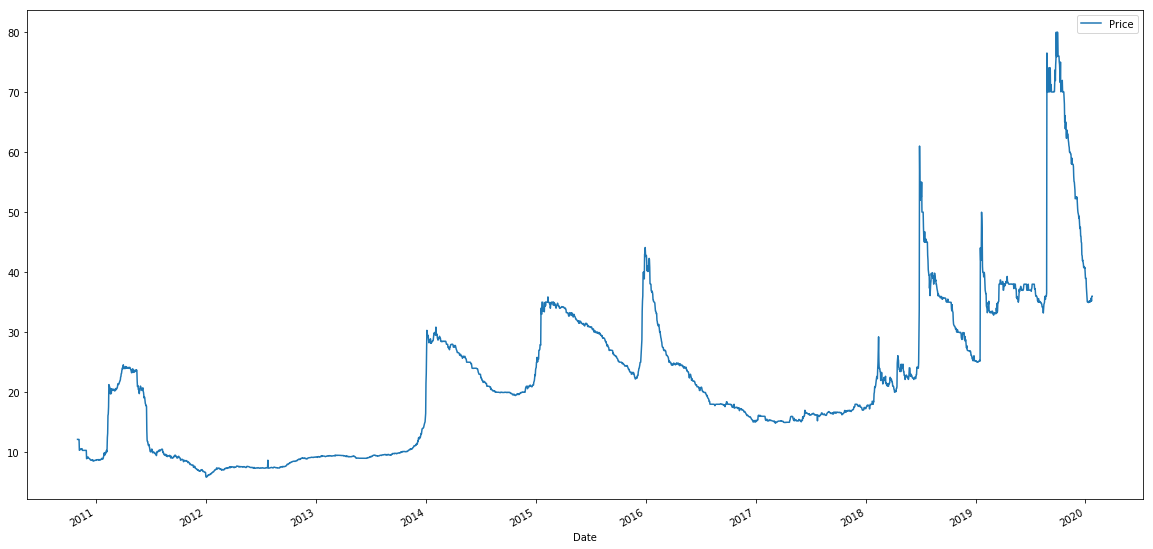

In [11]:
# Set card names and card_set
card_name= 'Stoneforge Mystic'
card_set = 'Worldwake'

SFM = scrape_data(card_name, card_set, save_data=True)

# Plot data
SFM.plot(figsize=(20,10))

Cool this is the same data from the lower graph outlined below:

![](Images/SFM_Zoomed_In.PNG)

Finally, let's test this function with another card called [Tarmogoyf](https://www.mtggoldfish.com/price/Future+Sight/Tarmogoyf#online) from the set "Future Sight" shown below.

![](Images/Tarmo_mtggoldfish.PNG)

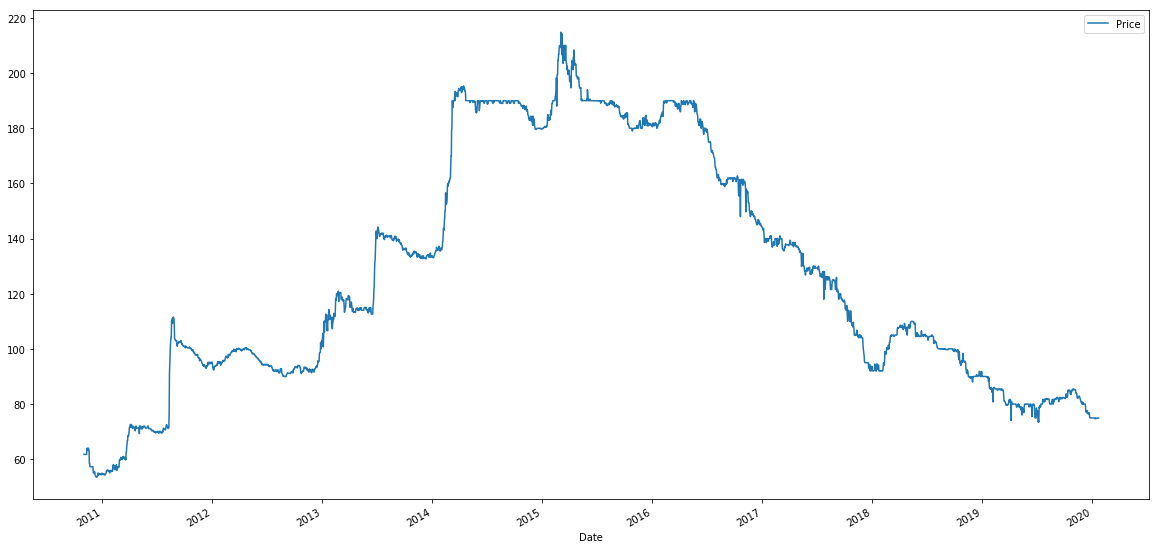

In [16]:
# Set card names and card_set
card_name= 'Tarmogoyf'
card_set = 'Future Sight'

Goyf = scrape_data(card_name, card_set)
# Uncomment in case we want to save the CSV locally
#SFM.to_csv("SFM_Prices.csv")

# Plot data
Goyf.plot(figsize=(20,10))

Awesome, now we have a reusable function that can grab the card's were interested in.  In order to call this function into our main notebook, we'll create a python script that just has the function.  